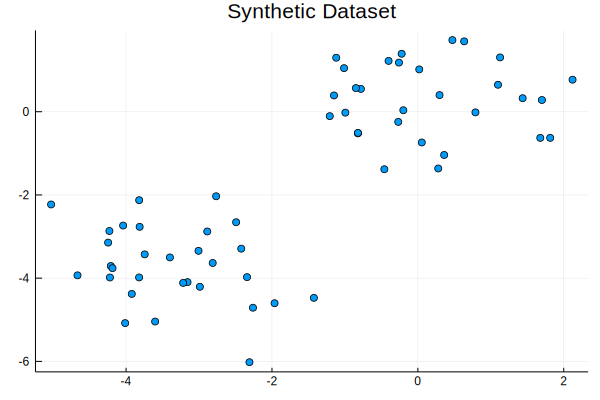

In [2]:
using Distributions, StatsPlots, Random

# Set a random seed.
Random.seed!(3)

# Construct 30 data points for each cluster.
N = 30

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0]

# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], 1.), N), hcat, 1:2)

# Visualization.
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

In [5]:
using Turing, MCMCChains

Turing.setprogress!(true);

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /home/anatoly/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as true
└ @ AdvancedVI /home/anatoly/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


In [6]:
@model GaussianMixtureModel(x) = begin
    
    D, N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()
    
    # Draw the parameters for cluster 2.
    μ2 ~ Normal()
    
    μ = [μ1, μ2]
    
    # Uncomment the following lines to draw the weights for the K clusters 
    # from a Dirichlet distribution.
    
    # α = 1.0
    # w ~ Dirichlet(2, α)
    
    # Comment out this line if you instead want to draw the weights.
    w = [0.5, 0.5]
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 1 method)

In [7]:
gmm_model = GaussianMixtureModel(x);

In [8]:
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))

Gibbs{(:k, :μ1, :μ2), Tuple{PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Core.ForwardDiffAD{40}, (:μ1, :μ2), AdvancedHMC.UnitEuclideanMetric}}}((PG{(:k,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(100, AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5)), HMC{Turing.Core.ForwardDiffAD{40}, (:μ1, :μ2), AdvancedHMC.UnitEuclideanMetric}(0.05, 10)))

In [9]:
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1:3);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:45
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:52
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:44


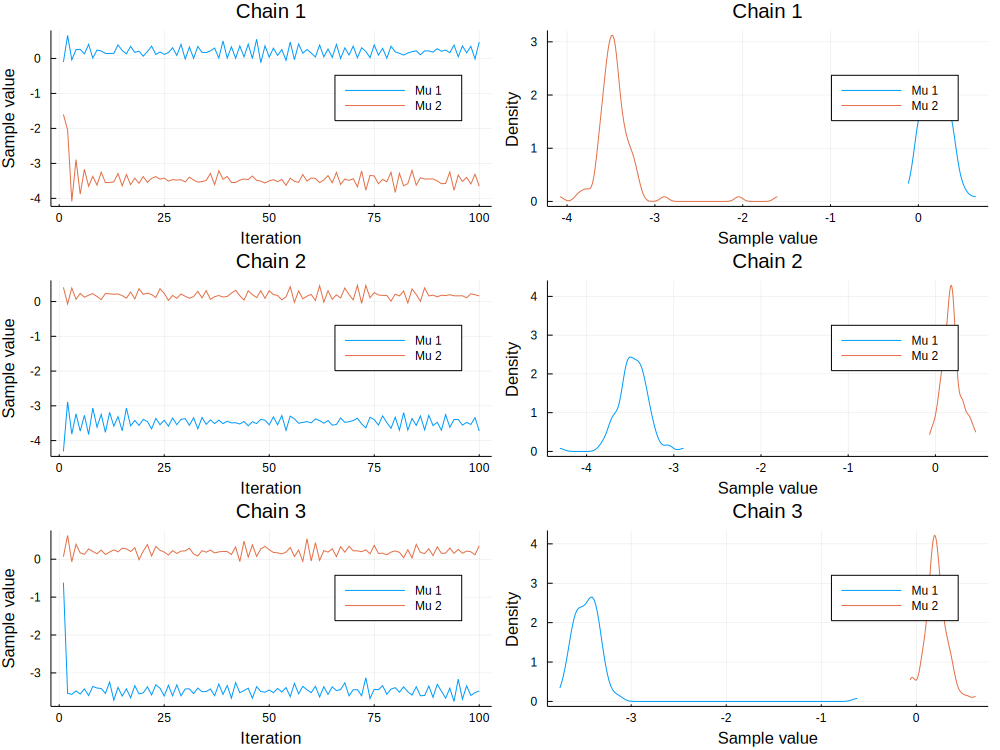

In [10]:
ids = findall(map(name -> occursin("μ", string(name)), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["Mu 1" "Mu 2"], colordim=:parameter)

In [11]:
tchain = tchain[:, :, 1];

In [12]:
# Helper function used for visualizing the density region.
function predict(x, y, w, μ)
    # Use log-sum-exp trick for numeric stability.
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x, y]), 
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x, y])
    )
end

predict (generic function with 1 method)

In [16]:
# contour(range(-5, stop = 3), range(-6, stop = 2), 
#     (x, y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1]), mean(tchain[:μ2])])
# )
# scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

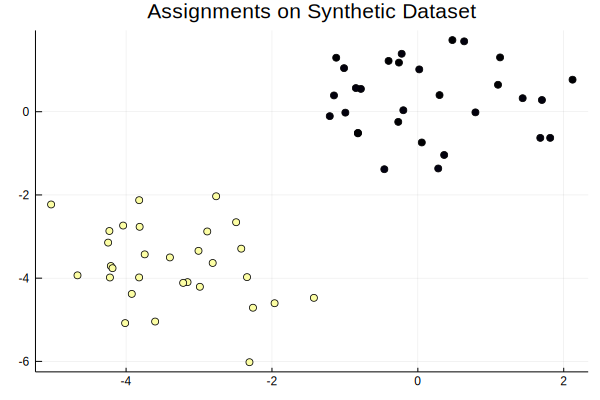

In [17]:
# TODO: is there a better way than this icky `.nt.mean` stuff?
assignments = mean(MCMCChains.group(tchain, :k)).nt.mean
scatter(x[1,:], x[2,:], 
    legend = false, 
    title = "Assignments on Synthetic Dataset", 
    zcolor = assignments)